Copyright 2023 Google LLC

Use of this source code is governed by an MIT-style
license that can be found in the LICENSE file or at
https://opensource.org/licenses/MIT.

# Instructions
Please run the following cells sequentially
1. (Optional) Running 1b adds semantic labels and requires addtional resources (default to a second GPU).
* The function relies on an additonal image captioning model, e.g., BLIP.  
* The labels are nouns, extracted from the generated caption. 
* It merge masks sharing the same label. 
2. Add your own image and update ``image_path`` variable. 
3. Feel free to play with DiffSeg hyper-parameters such as the ``KL_THRESHOLD``.

# Import

In [3]:
import tensorflow as tf
from PIL import Image
import nltk
from transformers import AutoProcessor, TFBlipForConditionalGeneration
from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from third_party.keras_cv.stable_diffusion import StableDiffusion 
from third_party.keras_cv.diffusion_model import SpatialTransformer
from diffseg.utils import process_image, augmenter, vis_without_label, semantic_mask
from diffseg.segmentor import DiffSeg

is_noun = lambda pos: pos[:2] == 'NN'
!nvidia-smi
nltk.download('all')

2025-02-16 20:46:53.072385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 20:46:53.072476: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 20:46:53.073382: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 20:46:53.168200: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Sun Feb 16 20:47:00 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:35:00.0 Off |                    0 |
| N/A   26C    P0              18W /  72W |  21165MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

2025-02-16 20:46:59.907974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /teamspace/studios/this_studio/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /teamspace/studios/this_studio/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /teamspace/studios/this_studio/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /teamspace/studios/this_studio/nltk

True

# 1. Initialize SD Model

In [4]:
# Inialize Stable Diffusion Model on GPU:0 
with tf.device('/GPU:0'):
  image_encoder = ImageEncoder()
  vae=tf.keras.Model(
            image_encoder.input,
            image_encoder.layers[-1].output,
        )
  model = StableDiffusion(img_width=512, img_height=512)
blip = None

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


# 1b. Initialize BLIP (optional)

In [5]:
# Optionally initalize a BLIP captioning model on GPU:1
with tf.device('/GPU:1'):
    processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip = TFBlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

2025-02-16 20:47:05.056335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
All model checkpoint layers were used when initializing TFBlipForConditionalGeneration.

All the layers of TFBlipForConditionalGeneration were initialized from the model checkpoint at Salesforce/blip-image-captioning-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBlipForConditionalGeneration for predictions without further training.


# 2. Run Inference on Real Images

In [6]:
# The first time running this cell will be slow
# because the model needs to download and loads pre-trained weights.

image_path = "./images/meme_test_2.jpg" # Specify the path to your image

if blip is not None:
  with tf.device('/GPU:1'):
    inputs = processor(images=Image.open(image_path), return_tensors="tf")
    out = blip.generate(**inputs)
    prompt = processor.decode(out[0], skip_special_tokens=True)
    print(prompt)
else:
  prompt = None

prompt= 'a kid with text '
prompt += ' with background'

with tf.device('/GPU:0'):
  images = process_image(image_path)
  images = augmenter(images)
  latent = vae(tf.expand_dims(images, axis=0), training=False)
  images, weight_64, weight_32, weight_16, weight_8, x_weights_64, x_weights_32, x_weights_16, x_weights_8 = model.text_to_image(
    prompt,
    batch_size=1,
    latent=latent,
    timestep=300
  )
  

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


fat fat kid mememe


# 3. Generate Segementation Masks

[(1, 'kid'), (3, 'text'), (5, 'background')]
<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]]
[0]
defaultdict(<class 'list'>, {'background': [0], 'text': [1], 'kid': [2, 3]})


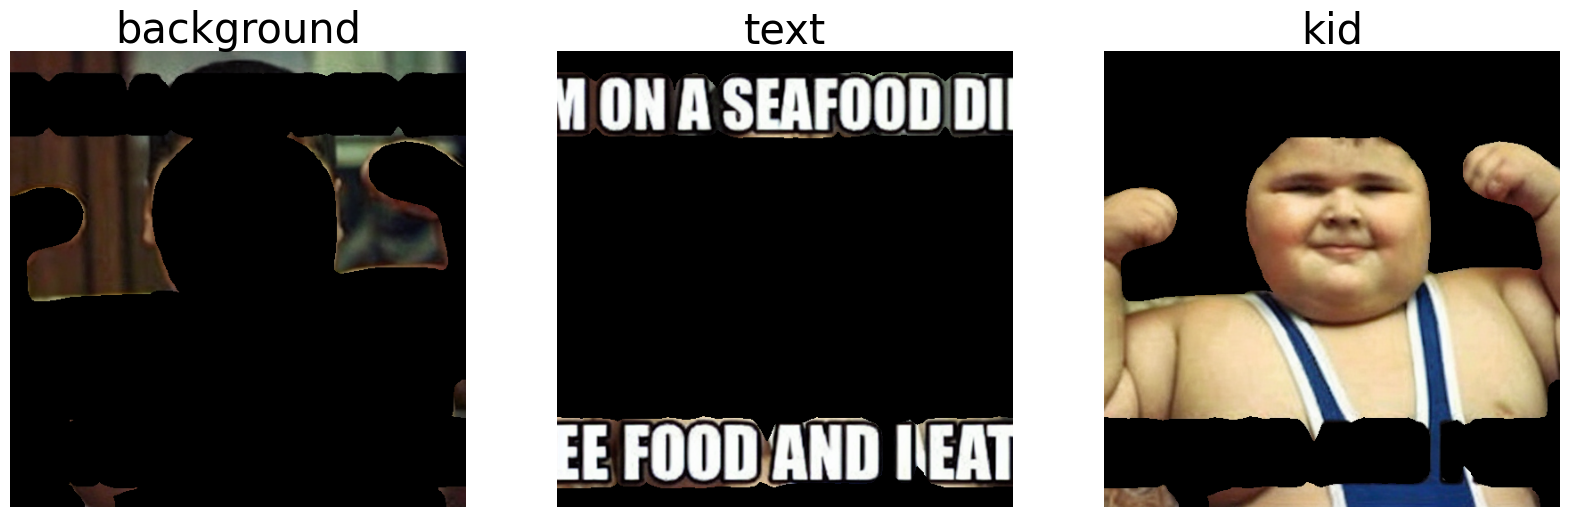

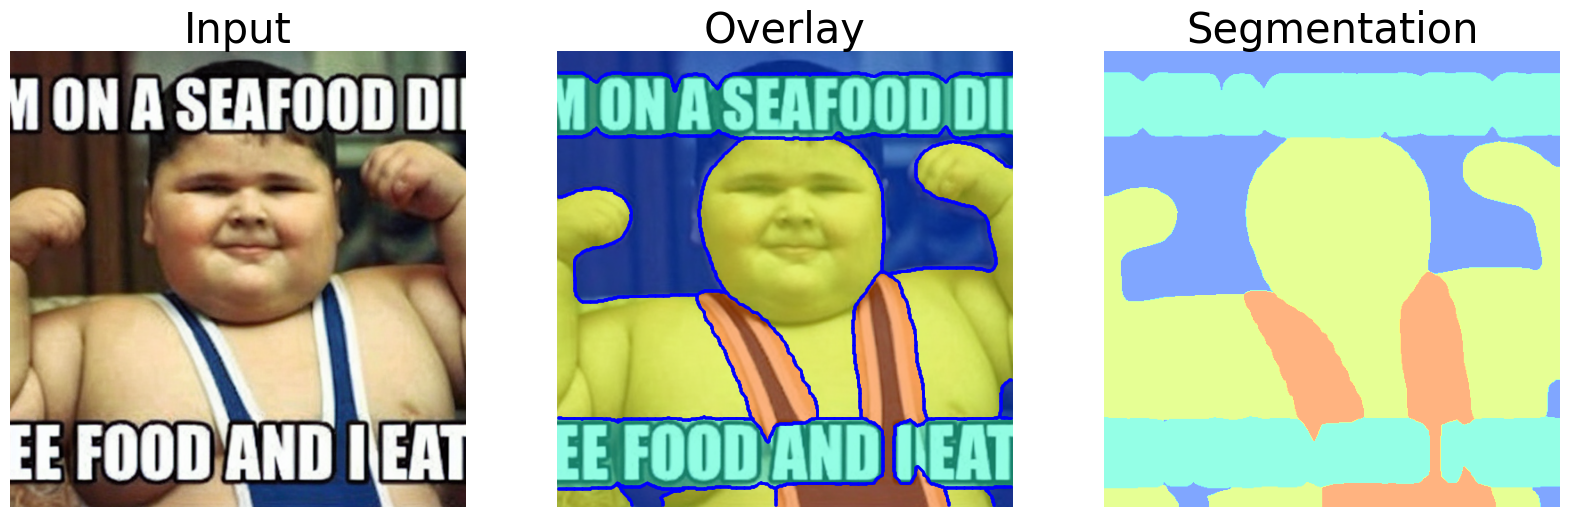

In [7]:
KL_THRESHOLD = [0.9]*3 # KL_THRESHOLD controls the merging threshold
NUM_POINTS = 32
REFINEMENT = True


with tf.device('/GPU:0'):
  segmentor = DiffSeg(KL_THRESHOLD, REFINEMENT, NUM_POINTS)
  pred = segmentor.segment(weight_64, weight_32, weight_16, weight_8) # b x 512 x 512
  if blip is not None:
    tokenized = nltk.word_tokenize(prompt)
    nouns = [(i,word) for i,(word, pos) in enumerate(nltk.pos_tag(tokenized)) if is_noun(pos)]
    print(nouns)

  for i in range(len(images)):
    if blip is not None:
      x_weight = segmentor.aggregate_x_weights([x_weights_64[i],x_weights_32[i], x_weights_16[i], x_weights_8[i]],weight_ratio=[1.0,1.0,1.0,1.0])
      label_to_mask = segmentor.get_semantics(pred[i], x_weight[i], nouns,voting="mean")
      print(type(images[i]))
      print(pred[i])
      print(label_to_mask['background'])
      print(label_to_mask)
      semantic_mask(images[i], pred[i], label_to_mask)
    vis_without_label(pred[i],images[i],num_class=len(set(pred[i].flatten())))

      

In [ ]:
import numpy as np

final_mask = label_to_mask
if final_mask.get('background') != None:
    del final_mask['background']
select = list(final_mask.values())
final_mask = {'final' : [item for sublist in select for item in sublist]}
print(final_mask)
for i in range(len(images)):
  semantic_mask(images[i], pred[i], final_mask)